In [4]:
import os
import h5py
import numpy as np
from matplotlib import pyplot as plt

import fastmri
from fastmri.data import transforms as T
#from fastmri.data.mri_data import fetch_dir
#from fastmri.data.subsample import create_mask_for_mask_type
#from fastmri.data.transforms import UnetDataTransform
#from fastmri.pl_modules import FastMriDataModule, UnetModule



In [9]:
train_path = '/home/yusuf/Desktop/projects/data/fastmri/multicoil_train'
val_path = '/home/yusuf/Desktop/projects/data/fastmri/multicoil_val'
file_list = os.listdir(train_path)
file_name = f'{train_path}/{file_list[4]}'
hf = h5py.File(file_name)

In [3]:
print('Keys:', list(hf.keys()))
print('Attrs:', dict(hf.attrs))

Keys: ['ismrmrd_header', 'kspace', 'reconstruction_rss']
Attrs: {'acquisition': 'AXT2', 'max': 0.0006489486017268892, 'norm': 0.13129568251285575, 'patient_id': '5c8bf4b5d9a1bddaffac9352be8cf2913078045bf6f03748608aa23801f90324'}


In [10]:
### no need to run each time || check for data shape compliance
dtchecklist = []
shchecklist = []
for i,file in enumerate(file_list):
    hf = h5py.File(f'{train_path}/{file}')
    volume_kspace = hf['kspace'][()]
    dtchecklist.append(volume_kspace.dtype)
    shchecklist.append(volume_kspace.shape)
np.all([i==(16, 5, 640, 322) for i in shchecklist])

KeyboardInterrupt: 

In [12]:
shchecklist

[(16, 5, 640, 322),
 (16, 20, 640, 320),
 (16, 16, 640, 320),
 (16, 4, 640, 320),
 (16, 14, 768, 396),
 (16, 4, 640, 320),
 (16, 20, 768, 396),
 (16, 16, 640, 320),
 (16, 12, 768, 396),
 (16, 12, 768, 396),
 (16, 4, 640, 320),
 (16, 16, 640, 320),
 (16, 14, 768, 396),
 (16, 20, 768, 396),
 (16, 4, 640, 320),
 (16, 20, 768, 396),
 (16, 20, 640, 320),
 (16, 16, 640, 320),
 (16, 16, 640, 320),
 (16, 4, 640, 320),
 (16, 16, 640, 320),
 (16, 16, 640, 320),
 (16, 20, 640, 320),
 (16, 10, 640, 320),
 (16, 4, 640, 322),
 (16, 16, 768, 396),
 (14, 20, 640, 320),
 (16, 20, 768, 396),
 (16, 16, 768, 396),
 (16, 4, 640, 320),
 (14, 4, 640, 320),
 (16, 20, 640, 320),
 (16, 20, 768, 396),
 (16, 12, 640, 320),
 (16, 16, 640, 320),
 (14, 6, 640, 320),
 (16, 6, 640, 320),
 (16, 20, 768, 396),
 (16, 14, 768, 396),
 (16, 20, 768, 396),
 (16, 14, 768, 396),
 (16, 16, 640, 320),
 (16, 4, 768, 392),
 (16, 20, 768, 396),
 (16, 12, 768, 396),
 (16, 12, 768, 396),
 (16, 4, 640, 322),
 (16, 16, 640, 320),
 (16,

In [13]:
volume_kspace = hf['kspace'][()]
slice_kspace = volume_kspace[6] # Choosing the *6-th slice of this volume
volume_kspace.shape

(16, 20, 768, 396)

In [14]:
# function to plot specific coils
def show_coils(data, slice_nums, cmap="gray"):
    fig = plt.figure()
    for i, num in enumerate(slice_nums):
        plt.subplot(1, len(slice_nums), i + 1)
        plt.imshow(data[num], cmap=cmap)

In [15]:
slice_kspace2 = T.to_tensor(slice_kspace)      # Convert from numpy array to pytorch tensor
slice_image = fastmri.ifft2c(slice_kspace2)           # Apply Inverse Fourier Transform to get the complex image
slice_image_abs = fastmri.complex_abs(slice_image)   # Compute absolute value to get a real image

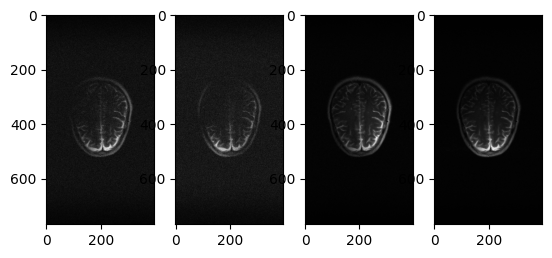

In [21]:
show_coils(slice_image_abs, [0,1,2,3])

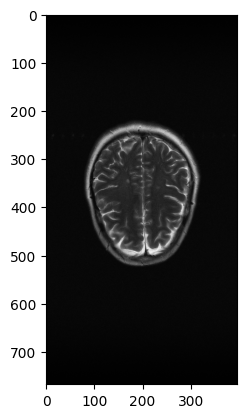

In [22]:
slice_image_rss = fastmri.rss(slice_image_abs, dim=0)
plt.imshow(np.abs(slice_image_rss.numpy()), cmap='gray')

In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from fastmri.data.subsample import create_mask_for_mask_type
from fastmri.data.transforms import UnetDataTransform
from fastmri.data.mri_data import SliceDataset
from fastmri.models import Unet

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
from fastmri.data.subsample import RandomMaskFunc

# choose mask func
mask = create_mask_for_mask_type(mask_type_str="random",center_fractions=[0.08],accelerations=[4])
mask = RandomMaskFunc(center_fractions=[0.04], accelerations=[8])  # Create the mask function object
train_transform = UnetDataTransform(which_challenge="multicoil", mask_func=mask, use_seed=False)
val_transform = UnetDataTransform(which_challenge="multicoil", mask_func=mask)


In [12]:
train_path = '/home/yusuf/Desktop/projects/data/fastmri/multicoil_train/'
val_path = '/home/yusuf/Desktop/projects/data/fastmri/multicoil_val/'

In [13]:
train_dataset = SliceDataset(
    root=train_path,
    transform=train_transform,
    challenge="multicoil"
)
val_dataset = SliceDataset(
    root=val_path,
    transform=val_transform,
    challenge="multicoil"
)

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False, num_workers=4)


IsADirectoryError: [Errno 21] Unable to open file (file read failed: time = Fri Nov  1 17:56:04 2024
, filename = '/home/yusuf/Desktop/projects/data/fastmri/multicoil_train/multicoil_train', file descriptor = 82, errno = 21, error message = 'Is a directory', buf = 0x7ffebfa7abe0, total read size = 8, bytes this sub-read = 8, bytes actually read = 18446744073709551615, offset = 0)

In [40]:
h5py.__version__

'3.12.1'